# Extending Hastings' thresholding algorithm

This was initially proposed in https://arxiv.org/pdf/1905.07047.pdf as a classical competitor to QAOA for MaxCut.

It works on D-regular, N-node graphs as follows:
* Randomly assign a spin (±1) to each node.
* For each spin, if at least T / D neighbors have the same spin, flip the spin.
* The number of cuts in MaxCut is the number of edges ($0\le K \le DN/2$) that have nodes with different spins. 


Hastings defines performance $-0.5 \le \delta \le 0.5$ compared to a random partitioning of equal size, which on average would cut half the edges:
$$
K = (1/2 + \delta)(DN/2)
$$

Optimizing threshold T for each D almost always outperforms 1-step QAOA on D-regular triangle-free graphs, but with the same scaling $\delta \propto D^{-0.5}$.


---

## Goal 1: Reproduce Hastings' numerical performance results for MaxCut.

This was completed on July 7 2020.

Hastings analyzes a subgraph of node $i$ and $j$ and their other neighbors. He defines the following functions:
* $q(k)$ decides whether or not to "flip the spin". Here, $k$ is the number of neighbors with same spin. $q(k) = -1$ if $k \ge T$, otherwise $+1$.
* $P_n(k)$ is the binomial probability distribution ${n \choose k}2^{-n}$, given $n$ neighbors not including $j$. In Hastings' analysis, $n=D-1$.

Hastings computes the correlation function $\langle Z_i Z_j \rangle$, where $Z_l$ is the spin $\pm 1$ of node $l$. $\langle Z_i Z_j \rangle$ is the chance the nodes have the same spin (+1), subtracting the chance the nodes have opposite spin (-1). Thus, $1/2(1 - \langle Z_i Z_j \rangle)$ is 1 if the nodes have opposite spin, and 0 if the nodes have the same spin.

Since all subgraphs are identical, one can use linearity of expectation to count the number of edges to cut:
$$
K = (DN/2)(1/2)(1 - \langle Z_i Z_j \rangle)
$$

So, the performance $\delta = (-1/2)\langle Z_i Z_j \rangle$.

Hastings conducts the analysis for triangle-free graphs. Nodes $i$ and $j$ agree in spin with 1/2 chance. The below formulas show how $Z_i$ and $Z_j$ will update.
* If they do agree, $Z_i = Z_j = (\sum_{k=0}^{d-1} P_{d-1}(k) q(k+1))$. 
* If not,  $Z_i = - Z_j = (\sum_{k=0}^{d-1} P_{d-1}(k) q(k))$

So, we can compute $\langle Z_i Z_j \rangle$:
$$
\langle Z_i Z_j \rangle = 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k+1))^2 - 1/2 (\sum_{k=0}^{d-1} P_{d-1}(k) q(k))^2
$$



### Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

In [363]:
def qsimple(k, threshold):
    return -1 if k >= threshold else 1

def q(k, threshold):
    """Like qsimple above, but also works for numpy arrays"""
    return (1-(k >= threshold)*2)

def test_qs():
    """Test q and qsimple methods"""
    assert q(2, 3) ==  1 == qsimple(2, 3), "testing q less than threshold"
    assert q(3, 3) == -1 == qsimple(3, 3), "testing q equal to threshold"
    assert q(3, 2) == -1 == qsimple(3, 2), "testing q higher than threshold"
    assert np.all(q(np.array([2,3,4]), 3) == np.array([1, -1, -1])), "list of q"
    assert np.all(q(np.array([2,3,4]), 3) == [qsimple(2, 3), qsimple(3,3), qsimple(4,3)]), "list of q"
    
test_qs()

In [364]:
def calc_performance(D, T):
    """
    This calculates the performance over random after 1 step of Hastings' thresholding algorithm. 
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    # go through # of agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out two copies of 2^-n, n=D-1
        s1 += binom(D-1, i)*q(i+1, T)
        s2 += binom(D-1, i)*q(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

In [365]:
def test_all_thresholds(D, fn):
    """
    Gets performance over random for all possible thresholds (from 0 through D+1).
    Returns all results.
    """
    return [fn(D, T) for T in range(D+2)]

def print_max(D, results):
    """Finds and prints out the maximum performance in the input list."""
    print("D =", D, "T =", results.index(max(results)), "performance =", max(results))
    
def plot_by_T(D, results, label_prefix=""):
    plt.plot(range(len(results)), results, label=label_prefix + "D=" + str(D))
    plt.xlabel("min threshold to switch")
    plt.ylabel("performance $\delta$")

### scratch

In [366]:
def calc_performance_qf(D, T, qf):
    """
    This calculates the performance over random after 1 step of Hastings' thresholding algorithm. 
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    # go through # of agreeing neighbors, from 0 through D-1
    for i in range(D):
        # factor out two copies of 2^-n, n=D-1
        s1 += binom(D-1, i)*qf(i+1, T)
        s2 += binom(D-1, i)*qf(i, T)
    return -0.5 * 0.5 * (s1**2 - s2**2) * 2**(-2*(D-1))

In [367]:
def test_all_thresholds_qf(D, fn, qf):
    """
    Gets performance over random for all possible thresholds (from 0 through D+1).
    Returns all results.
    """
    return [fn(D, T, qf) for T in range(D+2)]

In [386]:
def make_q2(s):
    return lambda k, t: 1*(k <= t-1) + s*(k == t) + s*(k > t)

D = 60 T = 34 performance = 0.04353484029031557
D = 60 T = 33 performance = 0.04126073420454142
D = 60 T = 33 performance = 0.03652996240136369
D = 60 T = 32 performance = 0.02961869459244794
D = 60 T = 32 performance = 0.019744282633956917
D = 60 T = 34 performance = 0.00759229549866941


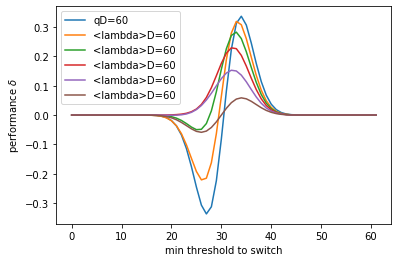

In [402]:
D = 60
inps = np.linspace(-0.8, 1, 5)
outs = []
for qf in [q] + [make_q2(s) for s in inps]:
    results = test_all_thresholds_qf(D, calc_performance_qf, qf)
    outs.append(max(results)*D)
    print_max(D, results)
    plot_by_T(D, D**0.5*np.array(results), qf.__name__)
plt.legend()
# plt.plot(inps, outs[1:])

In [ ]:
D = 299
inps = np.linspace(-1, 1, 5)
outs = []
for qf in [q] + [make_q2(s) for s in inps]:
    results = test_all_thresholds_qf(D, calc_performance_qf, qf)
    outs.append(max(results)*D**0.5)
#     print_max(D, results)
#     plot_by_T(D, results, qf.__name__)
# plt.legend()
plt.plot(inps, outs[1:])

### Plots
This plots performance by chosen threshold. The maximum value should match Table 1 in Hastings' paper. Notice that performance vs T is a shifted odd function.

D = 2 T = 2 performance = 0.25
D = 3 T = 3 performance = 0.1875
D = 4 T = 3 performance = 0.140625
D = 5 T = 4 performance = 0.15625
D = 6 T = 5 performance = 0.1220703125
D = 7 T = 5 performance = 0.128173828125
D = 8 T = 6 performance = 0.11663818359375
D = 9 T = 6 performance = 0.107666015625
D = 10 T = 7 performance = 0.107666015625
D = 11 T = 7 performance = 0.09252548217773438
D = 12 T = 8 performance = 0.0986623764038086
D = 13 T = 9 performance = 0.08860141038894653
D = 14 T = 9 performance = 0.09050001204013824
D = 15 T = 10 performance = 0.0853198766708374
D = 16 T = 10 performance = 0.08332019206136465
D = 17 T = 11 performance = 0.08158713206648827
D = 18 T = 11 performance = 0.07705451361835003
D = 19 T = 12 performance = 0.07778230123221874


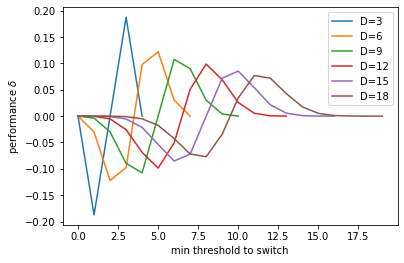

In [9]:
for D in range(2, 20):
    results = test_all_thresholds(D, calc_performance)
    print_max(D, results)
    if D % 3 == 0:
        plot_by_T(D, results)
plt.legend()

---

## Goal 2: Extend Hastings' algorithm analysis to graphs with triangles.

This was completed on July 7 2020.

### Graphs with one triangle
derivation at https://www.overleaf.com/read/thgyswvpgmwt

### Code (one triangle)

In [10]:
def calc_performance_one_triangle(D, T):
    """
    This calculates the performance over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including 1 triangle.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    s1 = 0
    s2 = 0
    s3 = 0
    # go through # of agreeing neighbors, from 0 through D-2
    for i in range(D-1):
        # factor out two copies of 2^-n, n=D-2
        s1 += binom(D-2, i)*q(i+2, T)
        s2 += binom(D-2, i)*q(i+1, T)
        s3 += binom(D-2, i)*q(i, T)
    return -0.5 * 0.25 * (s1**2 + s2**2 - 2*s2*s3) * 2**(-2*(D-2))

### Plots (one triangle vs triangle-free)

Notice that the maximum performance is slightly reduced when adding one triangle. 

Perhaps it is because $j$ is slightly more likely to be "in sync" with $i$; i.e. they will share switch/stay behavior if they share many neighbors.

It is also interesting that the minimum performance is also slightly reduced. (Why?)

D = 10 T = 7 performance = 0.107666015625
D = 10 T = 7 performance = 0.09271240234375


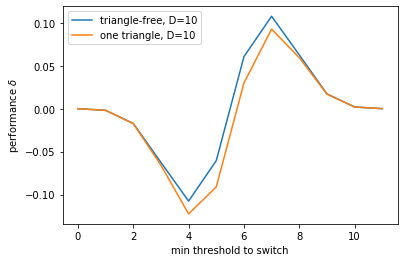

In [11]:
D=10
results = test_all_thresholds(D, calc_performance)
print_max(D, results)
plot_by_T(D, results, "triangle-free, ")

results = test_all_thresholds(D, calc_performance_one_triangle)
print_max(D, results)
plot_by_T(D, results, "one triangle, ")

plt.legend()

### Y triangles
Derivation at https://www.overleaf.com/read/thgyswvpgmwt

In [12]:
def calc_performance_y_triangles(D, T, Y):
    """
    This calculates the performance over random 
    after 1 step of Hastings' thresholding algorithm on a subgraph including Y triangles.
    Precisely, returns delta = -1/2 <Z_i Z_j> for D-regular graphs with threshold T.
    """
    p_k_vec = binom(D-1-Y, range(D-Y))
    out = 0
    for l in range(0, Y+1):
        q_kl1_vec = q(np.array(range(l+1, D-Y + l+1)), T)
        q_kl_vec = q(np.array(range(l, D-Y + l)), T)
        q_kyl_vec = q(np.array(range(Y-l, D-Y + Y-l)), T)
        f_dyl = sum(p_k_vec * q_kl1_vec)**2 - sum(p_k_vec * q_kl_vec)*sum(p_k_vec * q_kyl_vec)
        out += (f_dyl*binom(Y, l))
    # add powers of 2 at the end
    return -0.5 * 0.5 * out * 2**(-Y) * 2**((-2*(D-1-Y)))

In [13]:
def test_y_triangles_formula():
    """Tests Y triangle formula against 0 and 1 triangle formula."""
    assert calc_performance(5, 2) == calc_performance_y_triangles(5, 2, 0)
    assert calc_performance(5, 5) == calc_performance_y_triangles(5, 5, 0)
    assert calc_performance_one_triangle(5, 2) == calc_performance_y_triangles(5, 2, 1)

test_y_triangles_formula()

In [14]:
def calc_performance_y_triangles_curried(Y):
    """Creates a 2-argument function given number of triangles Y."""
    return lambda d, t: calc_performance_y_triangles(d, t, Y)

### Plots (triangle-free vs many triangles)

This confirms that the triangle-free results match the general results for Y=0.

D = 8 T = 6 performance = 0.11663818359375
D = 8 T = 6 performance = 0.11663818359375


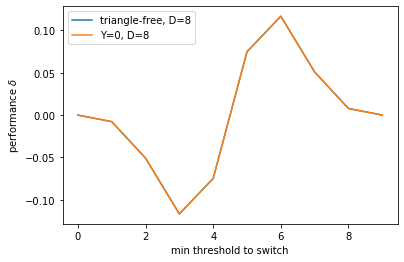

In [15]:
D=8
results = test_all_thresholds(D, calc_performance)
print_max(D, results)
plot_by_T(D, results, "triangle-free, ")

results = test_all_thresholds(D, calc_performance_y_triangles_curried(0))
print_max(D, results)
plot_by_T(D, results, "Y=0, ")

plt.legend()

This confirms that the one-triangle results match the general results for Y=1.

D = 8 T = 6 performance = 0.1007080078125
D = 8 T = 6 performance = 0.1007080078125


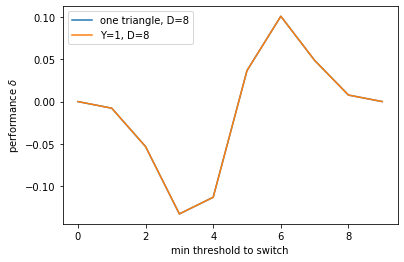

In [16]:
D=8
results = test_all_thresholds(D, calc_performance_one_triangle)
print_max(D, results)
plot_by_T(D, results, "one triangle, ")

results = test_all_thresholds(D, calc_performance_y_triangles_curried(1))
print_max(D, results)
plot_by_T(D, results, "Y=1, ")

plt.legend()

The more triangles shared by $i$ and $j$, the worse the performance. I think it is because the spin update of $i$ and $j$ are more influenced by the shared nodes than by the edge $E_{ij}$.

D = 12 T = 8 performance = 0.0986623764038086
D = 12 T = 8 performance = 0.08471488952636719
D = 12 T = 8 performance = 0.07089614868164062
D = 12 T = 8 performance = 0.0571441650390625
D = 12 T = 9 performance = 0.05065155029296875
D = 12 T = 9 performance = 0.044830322265625
D = 12 T = 9 performance = 0.03826904296875
D = 12 T = 9 performance = 0.03076171875
D = 12 T = 9 performance = 0.02197265625
D = 12 T = 9 performance = 0.01123046875
D = 12 T = 10 performance = 0.005126953125
D = 12 T = 0 performance = -0.0


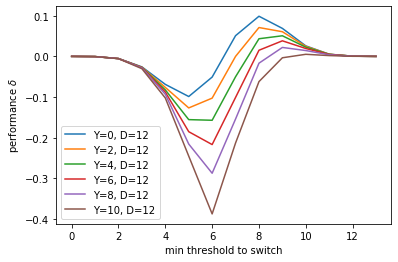

In [17]:
D=12
# from 0 through D-1 possible triangles
ys_to_plot = range(D)

for (results, y) in [(test_all_thresholds(D, calc_performance_y_triangles_curried(y)), y) for y in ys_to_plot]:
    print_max(D, results)
    if y % 2 == 0:
        plot_by_T(D, results, "Y=" + str(y) + ", ")
plt.legend()

The maximum performance decreases when adding triangles for all D.

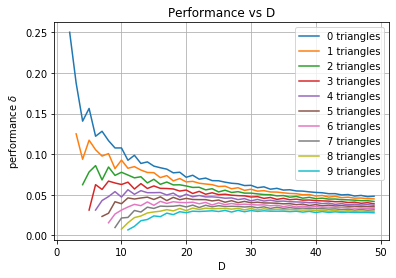

In [18]:
for y in range(10):
    ds = range(2+y, 50)
    fn = calc_performance_y_triangles_curried(y)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, deltas, label=str(y) + " triangles")
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

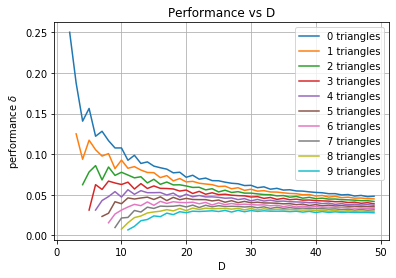

In [19]:
for y in range(10):
    ds = range(2+y, 50)
    fn = calc_performance_y_triangles_curried(y)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, deltas, label=str(y) + " triangles")
plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

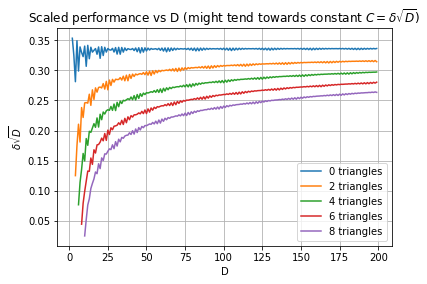

In [20]:
for y in range(0, 10, 2):
    ds = range(2+y, 200)
    fn = calc_performance_y_triangles_curried(y)
    cs = [d**0.5*max(test_all_thresholds(d, fn)) for d in ds]
    plt.plot(ds, cs, label=str(y) + " triangles")
plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("$\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

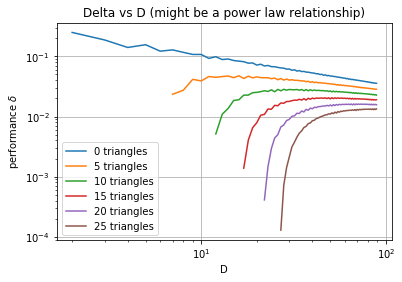

In [21]:
for y in range(0, 30, 5):
    ds = range(2+y, 90)
    fn = calc_performance_y_triangles_curried(y)
    deltas = [max(test_all_thresholds(d, fn)) for d in ds]
    plt.loglog(ds, deltas, label=str(y) + " triangles")
plt.title("Delta vs D (might be a power law relationship)")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

---

## Goal 3: Compare Hastings algorithm with QAOA on non-triangle-free graphs.
* See QAOA.ipynb for the analysis extending QAOA.
* I need to see if I can improve my grid-search approach to optimize QAOA angles.
* I want to draw plots to graph the two results together (perhaps for small D), and draw conclusions.


---

## Goal 4: Extend Hastings' algorithm analysis to p=2 for (n+1)-regular graphs, girth > 5

A full derivation is at https://www.overleaf.com/read/thgyswvpgmwt

All together, 

$$
\langle Z_i Z_j \rangle_2 = \sum_{k=0}^n \sum_{u=0}^n P_n(k) P_n(u) 
0.5\big(Z_{i2,k} Z_{j2,u}\Big\rvert_{Z_{i1} = q(k+1),Z_{j1} = q(u+1),Z_{i0}=Z_{j0} = 1} + Z_{i2,k} Z_{j2,u}\Big\rvert_{Z_{i1} = q(k),Z_{j1} = -q(u), Z_{i0}=1, Z_{j0} = -1}\big)
$$

## Goal 5: Plot p=2 Hastings algorithm results, over $\tau$

Assume the threshold is the same each time. This could be made different later...

In [22]:
import functools

In [23]:
def make_qfn(T):
    return lambda x: 1 if x < T else -1

qfns = [make_qfn(T) for T in range(10000)]

In [24]:
@functools.lru_cache(maxsize=4096)
def Z1plus(T, n):
    qf = qfns[T]
    return 2**(-n)*sum([binom(n, m)*qf(m+1) for m in range(0, n+1)])

@functools.lru_cache(maxsize=4096)
def Z1minus(T, n):
    qf = qfns[T]
    return (-1)*2**(-n)*sum([binom(n, m)*qf(m) for m in range(0, n+1)])

@functools.lru_cache(maxsize=4096)
def H(T, n, k,l,r):
    p_plus = (1 + Z1plus(T, n))/2
    p_minus = (1 + Z1minus(T, n))/2
    return p_plus**l * (1 - p_plus)**(k-l) * binom(k, l) * p_minus**r * (1 - p_minus)**(n-k-r) * binom(n-k, r)

@functools.lru_cache(maxsize=4096)
def bigQ(T, n, l, r, a, b):
    qf = qfns[T]
    return qf((n-l-r)*(1-a)/2 + (l+r)*(1+a)/2 + (1+b)/2)

In [25]:
@functools.lru_cache(maxsize=4096)
def Z2(Z1, Z0, match, T1, T2, n, k):
    out = 0
    for l in range(k+1):
        for r in range(n-k+1):
            out += H(T1, n, k, l, r)*bigQ(T2, n, l, r, Z1*Z0, match)
    return Z1*out

In [26]:
@functools.lru_cache(maxsize=4096)
def final(n, T1, T2):
    """
    Calculates -1/2 * <Z_i Z_j>
    """
    out = 0
    q1 = qfns[T1]
    for k in range(n+1):
        for u in range(n+1):
            equal = Z2(q1(k+1), 1, q1(k+1)*q1(u+1), T1, T2, n, k) * Z2(q1(u+1), 1, q1(k+1)*q1(u+1), T1, T2, n, k)
            unequal = Z2(q1(k), 1, -q1(k)*q1(u), T1, T2, n, k) * Z2(-q1(u), -1, -q1(k)*q1(u), T1, T2, n, k)
            out += binom(n, k) * binom(n, u) * 0.5 * (equal + unequal)
    return -0.5 * 2**(-2*n) * out

It should be odd function over the midpoint. Both T=0 and T> n+1 should be 0 (i.e. no improvement).

In [27]:
import time

In [28]:
# ! pip install line-profiler
# %load_ext line_profiler

In [29]:
# %lprun -f final final(70, makeq(3), makeq(3))

CPU times: user 1.73 s, sys: 7.96 ms, total: 1.74 s
Wall time: 1.74 s


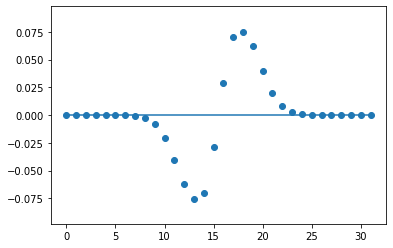

In [30]:
%%time
# recall that n = D-1
D=30
xs = range(D+2)
plt.scatter(xs, [final(D-1, t, t) for t in xs])
plt.plot(xs, [0]*len(xs))

In [31]:
def get_max_final(d):
    return max([final(d-1, t, t) for t in range(d+2)])

In [32]:
get_max_final(3)

0.191162109375

performance is decent until about n=60 it takes ~1s per data point

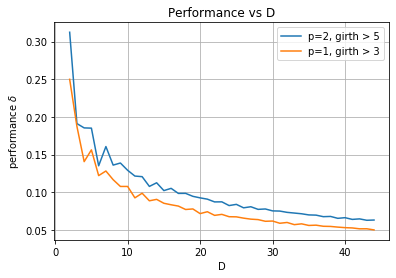

In [33]:
ds = range(2, 45)
deltas = [get_max_final(d) for d in ds]
plt.plot(ds, deltas, label="p=2, girth > 5")

fn = calc_performance_y_triangles_curried(0)
deltas = [max(test_all_thresholds(d, fn)) for d in ds]
plt.plot(ds, deltas, label="p=1, girth > 3")

plt.title("Performance vs D")
plt.xlabel("D")
plt.ylabel("performance $\delta$")
plt.legend()
plt.grid(True)

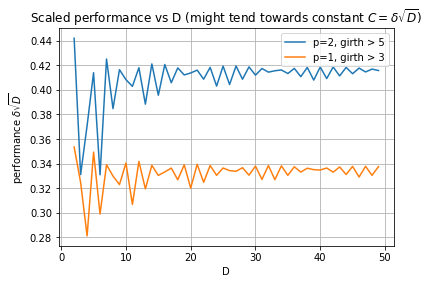

In [34]:
ds = range(2, 50)
deltas = [d**0.5 * max([final(d-1, t, t) for t in range(d+2)]) for d in ds]
plt.plot(ds, deltas, label="p=2, girth > 5")

fn = calc_performance_y_triangles_curried(0)
cs = [d**0.5*max(test_all_thresholds(d, fn)) for d in ds]
plt.plot(ds, cs, label="p=1, girth > 3")

plt.title("Scaled performance vs D (might tend towards constant $C = \delta \sqrt{D}$)")
plt.xlabel("D")
plt.ylabel("performance $\delta \sqrt{D}$")
plt.legend()
plt.grid(True)

----

# Asymptotic analysis of Hastings
August 20 2020

This presentation was given in the HRSS paper. It has fewer terms.
https://arxiv.org/pdf/1402.2543.pdf


In [189]:
def zi_zj(d, t):
    sum1 = sum([binom(d-1, k) for k in range(0, t-1)])
    sum2 = sum([binom(d-1, k) for k in range(t, d)])
    return 4**(1-d) * binom(d-1, t-1) * (sum1 - sum2)

In [36]:
import functools
import matplotlib.pyplot as plt
from scipy.special import binom
import numpy as np
from numpy import pi, exp, e

This formula is even simpler, assuming the threshold is above $D/2$, also from HRSS.

In [305]:
@functools.lru_cache()
def zi_zj_simpler(d, t):
    sum1 = sum([binom(d-1, k) for k in range(d-t+1, t)])
    return 4**(1-d) * binom(d-1, t-1) * sum1

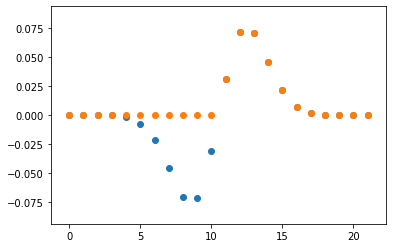

In [306]:
D=20
plt.scatter(range(D+2), [zi_zj(D,t) for t in range(D+2)])
plt.scatter(range(D+2), [zi_zj_simpler(D,t) for t in range(D+2)])

This plot ensures that the Hastings formula and HRSS formula are the same.

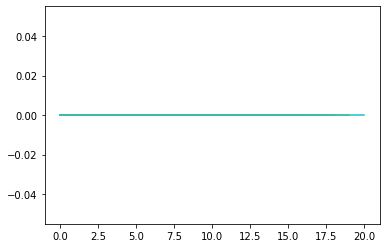

In [307]:
for D in range(20):
    results = test_all_thresholds(D, calc_performance)
    # print_max(D, results)
    # plot_by_T(D, results)
    plt.plot(range(D+2), [zi_zj(D,t)-results[t] for t in range(D+2)])
    # plt.legend()

In [308]:
outs = [0]*5
rang = range(5, 500)
for D in rang:
    inps = range(int(D/2), int(D/2+D**0.5))
    results= [zi_zj_simpler(D, t) for t in inps]
    outs.append(inps[np.argmax(results)])

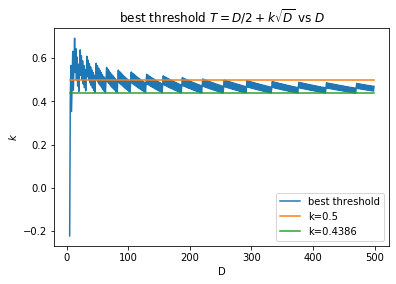

In [309]:
plt.plot(rang, [i**0.5*(outs[i]/i-0.5) for i in rang], label="best threshold")
plt.plot(rang, [1/2 for d in rang], label="k=0.5")
plt.plot(rang, [.4386 for d in rang], label="k=0.4386") # my guess at the best threshold
plt.title("best threshold $T = D/2 + k\sqrt{D}$ vs $D$")
plt.xlabel("D")
plt.ylabel("$k$")
plt.legend()

The above graph shows the best threshold at $0.4 \le k \le 0.5$.

### how close is the binomial coefficient approximation?

In [42]:
def test(n, k):
    return (2/(n*pi))**0.5 * exp(-2*k*k)

In [43]:
def exact(n,k):
    return 2**-n *binom(n, n/2 + k*n**0.5)

In [44]:
def test2(n, k):
    return (n/2 - k*n**0.5) / (n/2 + k*n**0.5 + 1)

compare n choose k with asymptotic error terms (scale with $n^{-3/2}$)

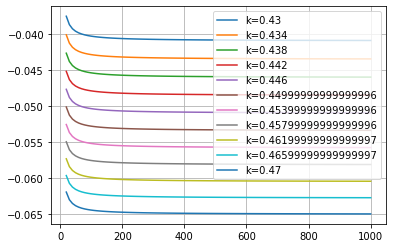

In [45]:
# k above ~ 1/e it will go below zero!
for k in np.linspace(0.43, 0.47, 11):
    f = lambda n: (test(n,k) - exact(n,k))*n**1.5
    inps = np.linspace(20, 1000, 100)
    plt.plot(inps, f(inps), label="k=" + str(k))
plt.legend()
plt.grid()

## compare binom sum with real thing

In [46]:
from scipy.special import erf

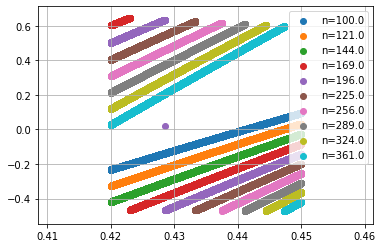

In [47]:
for n in np.linspace(10, 19, 10)**2:
    sumexact = lambda k: 2**-n*sum([binom(n, i) for i in range(int(n/2 - k*n**0.5), int(n/2 + k*n**0.5))])
    sumapprox = lambda k: erf(k*2**0.5)
    inps = np.linspace(0.42, 0.45, 20000)
    plt.scatter(inps, [(sumapprox(i)-sumexact(i))*n**0.5 for i in inps], label="n=" + str(n))
plt.legend()
plt.grid()

## Error analysis via normal approximation

In [48]:
def Phi(z):
    return 0.5*(1 + erf(z*2**-0.5))

In [354]:
def normal_approx(D, t):
    n = D-1
    mu = n/2
    var = n/4
    integral = Phi((t-1 - mu)*var**-0.5) - Phi((D-t - mu)*var**-0.5)
    return 2**(1-D)*binom(D-1, t-1)*integral

In [343]:
def normal_approx_improved(D, t):
    k= (t - D/2)*D**-0.5
    n = D-1
    mu = n/2
    var = n/4
    integral = erf(2**-0.5 * (2*k*(D/(D-1))**0.5 - (D-1)**-0.5))
    #same as below
    #integral = Phi((t-1 - mu)*var**-0.5) - Phi((D-t - mu)*var**-0.5)
    return (2/(pi*(D-1)))**0.5 * exp((-1/(2*n)) * (D-2*t + 1)**2) * integral

In [344]:
def normal_approx_symmetric(D, t):
    k= (t - D/2)*D**-0.5
    n = D-1
    mu = n/2
    var = n/4
    integral = erf(k*2**0.5)
    return (2/(pi*(D-1)))**0.5 * exp((-1/(2*n)) * (D-2*t + 1)**2) * integral

In [345]:
def normal_approx_sym2(D, t):
    k= (t - D/2)*D**-0.5
    return (2/(pi*(D-1)))**0.5 *exp(-2*k*k)* erf(k*2**0.5)

In [346]:
def normal_easy(k):
    return (2/pi)**0.5 * exp(-2*k*k)*erf(k*2**0.5)

## maximum value of f(k)

In [347]:
binom(1000, 500)

2.7028824094560503e+299

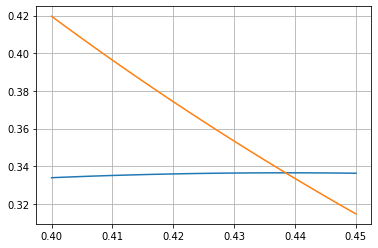

In [348]:
inps = np.linspace(0.4, 0.45, 100)
kmax = lambda k: exp(-4*k*k)/(k*pi) # when f'(k) = 0
plt.plot(inps, normal_easy(inps))
plt.plot(inps, kmax(inps))
plt.grid()

In [349]:
exp(.01)

1.010050167084168

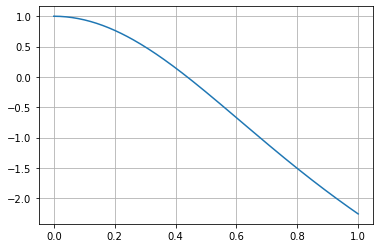

In [350]:
# this is f'(k)
simple = lambda k: exp(-2*k*k) - (2*pi)**0.5 * k * erf(k*2**0.5)
inps = np.linspace(0, 1, 200)
plt.plot(inps, simple(inps))
plt.grid()

k_max = 0.43848
performance/sqrt{D} = 0.3364933629451221


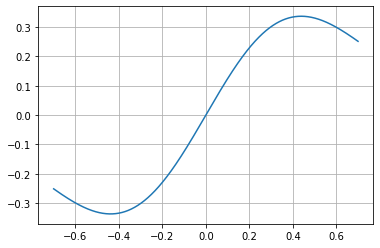

In [351]:
# asymptotic of best...
# matches hastings numerical approach of 0.34
rang = np.arange(20000)/(20000/1.4) - 0.7
results = [normal_easy(k) for k in rang]
plt.plot(rang, results)
print("k_max =", rang[np.argmax(results)])
print("performance/sqrt{D} =",max(results))
plt.grid()

### make successive approximations, what is the error?

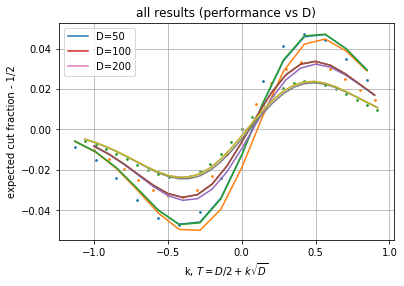

In [352]:
for D in [50, 100, 200]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.plot(krang, [zi_zj(D,t) for t in rang], label="D=" + str(D))
    plt.plot(krang, [normal_approx(D, t) for t in rang])
    plt.plot(krang, [normal_approx_improved(D, t) for t in rang])
    plt.scatter(krang, [D**-0.5*normal_easy((t-0.5*D)*D**-0.5) for t in rang], s=3)
    plt.legend()
    plt.title("all results (performance vs D)")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("expected cut fraction - 1/2")
    plt.grid()

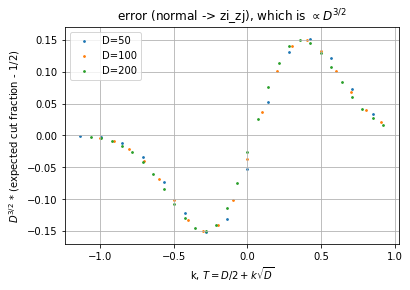

In [355]:
for D in [50, 100, 200]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [D**1.5*normal_approx(D, t) - D**1.5*zi_zj(D, t) for t in rang], s=3, label="D=" + str(D))
    plt.title("error (normal -> zi_zj), which is $\propto D^{3/2}$")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("$D^{3/2}$ * (expected cut fraction - 1/2)")
    plt.legend()
    # approximation is ~ 0.15 / n^3/2 ... approx bigger by 1/\sqrt{n} * 0.15 / n ... maximized at k_max
    # could be related to D vs D-1 sub

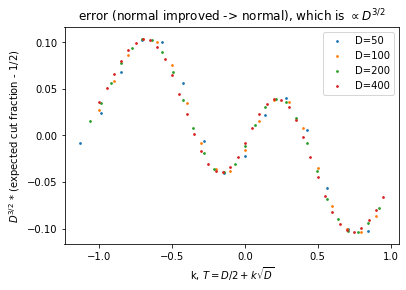

In [357]:
for D in [50, 100, 200, 400]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [D**1.5*normal_approx_improved(D, t) - D**1.5*normal_approx(D, t) for t in rang], s=3, label="D=" + str(D))
    plt.title("error (normal improved -> normal), which is $\propto D^{3/2}$")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("$D^{3/2}$ * (expected cut fraction - 1/2)")
    plt.legend()
    # approximation is ~ 0.12 / n^3/2 ... could be related to D vs D-1 sub   

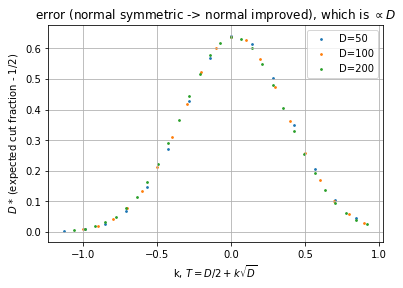

In [324]:
for D in [50, 100, 200]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [D*normal_approx_symmetric(D, t) - D*normal_approx_improved(D, t) for t in rang], s=3, label="D=" + str(D))
    plt.title("error (normal symmetric -> normal improved), which is $\propto D$")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("$D$ * (expected cut fraction - 1/2)")
    plt.legend()
    # approximation is ~ 0.7 / n .. looks like .7* e^-2k^2 / n .. makes sense it's missing the binomial expression

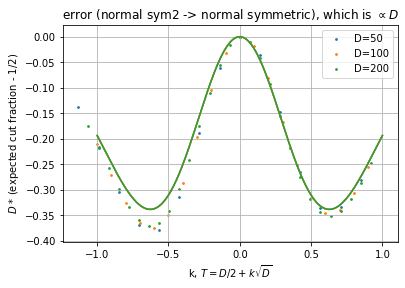

In [93]:
for D in [50, 100, 200]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [D*normal_approx_sym2(D, t) - D*normal_approx_symmetric(D, t) for t in rang], s=3, label="D=" + str(D))
    plt.title("error (normal sym2 -> normal symmetric), which is $\propto D$")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("$D$ * (expected cut fraction - 1/2)")
    plt.legend()
    # approximation is ~ -0.35 / n .. looks like (e^-4k^2 - e^-2k^2) / n.. but it's < 0 !!!
    # where does the negative influence come from?
    test2 = lambda x: 1.5*exp(-2*x*x) * (exp(-2*x*x)-1) # can I derive this approximation? e^-2k^2(0.6 - 2.5x^2)?
    test3 = lambda x: -1.5*erf(x*2**0.5)*exp(-2*x*x)*x # systematic undershoot from e^-2k^2 (1 - 2k/ \sqrt{D})
    # threshold is slightly high... is actually D/2 - 1/2
    plt.plot(np.linspace(kmin, kmax, 300), test3(np.linspace(kmin, kmax, 300)))   

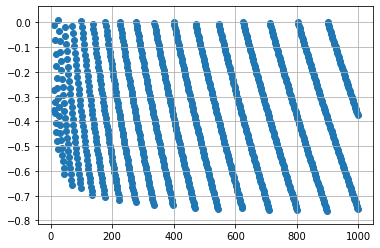

In [264]:
# TEST binom coeff approx
inps = range(10, 1000, 1)
k=0.3
plt.scatter(inps, [n*((2/pi/n)**0.5 * exp(-2*k*k) - 2**-n * binom(n, int(n/2 + k*n**0.5))) for n in inps])
plt.grid()
# plt.ylim(-.01, .01)

In [277]:
.33649*.98

0.3297602

In [302]:
g = lambda k, D: Phi(2*k - (D-1)**-0.5) - Phi(-2*k + 3*(D-1)**-0.5)
gs = lambda k, D: Phi(2*k) - Phi(-2*k)

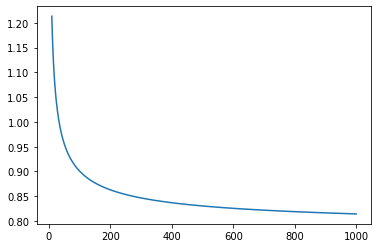

In [304]:
k=0.6
inps = range(10, 1000)
plt.plot(inps, [D**0.5*(gs(k, D) - g(k, D)) for D in inps])

In [274]:
(1/1000)**.5

0.03162277660168379

In [242]:
# another test
k=0.1
D=1000
erf(2**0.5 * k * (1 + 1/(D-1))**0.5) / erf(2**0.5 * k)

1.0004937342143372

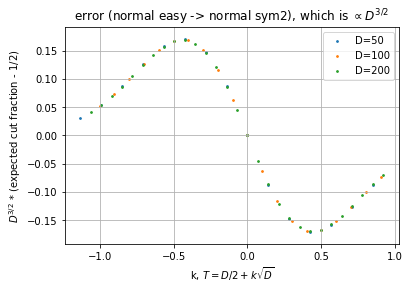

In [234]:
for D in [50, 100, 200]:
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [D*normal_easy((t-0.5*D)*D**-0.5) - D**1.5*normal_approx_sym2(D, t) for t in rang], s=3, label="D=" + str(D))
    # normal easy is off by 0.15 / n^3/2 .. from the D vs D-1 thing
    plt.title("error (normal easy -> normal sym2), which is $\propto D^{3/2}$")
    plt.xlabel("k, $T = D/2 + k\sqrt{D}$")
    plt.ylabel("$D^{3/2}$ * (expected cut fraction - 1/2)")
    plt.legend()

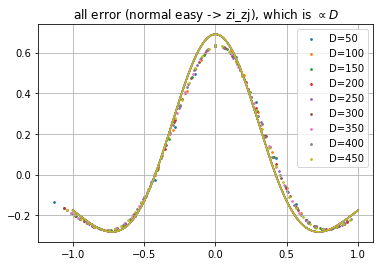

In [362]:
for D in range(50, 500, 50):
    kmin =-1
    kmax=1
    rang = np.arange(int(D/2 + kmin*D**0.5), int(D/2 + kmax*D**0.5))
    krang = (rang-D/2)*D**-0.5
    
    plt.grid()
    plt.scatter(krang, [(D**0.5*normal_easy((t-0.5*D)*D**-0.5) - D*zi_zj(D, t)) for t in rang], s=3, label="D=" + str(D))
    test = lambda x: 2.3*exp(-2*x*x) * (exp(-2*x*x)-0.7) # can I derive this approximation? e^-2k^2(0.6 - 2.5x^2)?
    plt.plot(np.linspace(kmin, kmax, 300), test(np.linspace(kmin, kmax, 300)))
    plt.title("all error (normal easy -> zi_zj), which is $\propto D$")
    plt.legend()  
    
# approximation is ~ 0.65 / n at k=0... bigger by 1/\sqrt{n} * 0.65 / \sqrt{n}
# at k_max, it's much smaller..
# the approximation is e^-2k^2 (a - bk^2) / n ..

0.33/\sqrt{D} is overshoot by 0.3/D

In [98]:
0.33 - 0.3/\sqrt{D} --> 

SyntaxError: unexpected character after line continuation character (<ipython-input-98-770b4659f349>, line 1)

In [103]:
0.5*1000**-0.5

0.015811388300841896

In [109]:
.336*.7

0.2352

In [202]:
exp(-2*0.3*0.3)

0.835270211411272

In [206]:
erf(0.5*2**0.5)

0.6826894921370859

In [207]:
.68*.7

0.476

In [208]:
.84-.47

0.37

In [213]:
1/1000**0.5

0.03162277660168379

## new algorithm

similar to Hastings D=3,4 alg. start uniform. "rocks and pebbles" is what I call it

In [522]:
def measure(trials, D, c):
    successes = 0
    for _ in range(trials):
        rands = np.random.rand(2*D)*2 - 1
        a = rands[0]
        k = sum(rands[1:D])
        b = rands[D]
        l = sum(rands[D+1:])
        if np.sign(a + c*k + c*b) != np.sign(b + c*l + c*a):
            successes += 1
    return (successes/trials - 0.5)*D**0.5

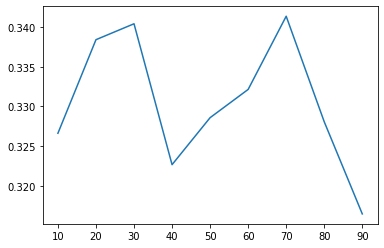

In [546]:
inps = range(10, 100, 10)
plt.plot(inps, [measure(100000, D, -D**-0.5) for D in inps])

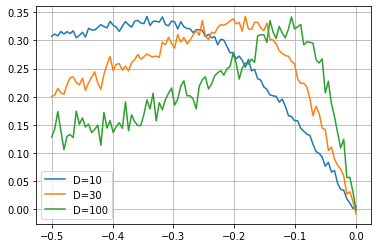

In [508]:
for D in [10, 30, 100]:
    cs = np.linspace(-0.5, 0, 100)
    outs = []
    for c in cs:
        trials = 100000
        outs.append(measure(trials, D, c))
    plt.plot(cs, outs, label="D=" + str(D))
plt.legend()
plt.grid()

In [513]:
.173*3**-0.5

0.09988159656980525

looks like $c \approx 1/\sqrt{D}$

In [ ]:
.3, .2, .1... -> *3 -> 

Initial checks. doesn't look like it performs much better (or worse) than the HRSS, best still > $1/2 + .3/\sqrt{D}$

 as D gets large, then k, l are from uniform distribution.

# another more general idea

In [1754]:
# r is triangle distribution
def P(a, b, z, s, D, r=0):
    rtD1 = (D-1)**0.5
    bma = Phi((b+r)/s/rtD1 - a/z/s)
    amb = Phi((a+r)/s/rtD1 - b/z/s)
    return bma*(1 - amb) + amb*(1 - bma)

In [1755]:
# should be identical to P
# so need to average < erf x erf y > over distribution to get performance
def P2(a, b, z, s, D):
    rtD1 = (D-1)**0.5
    return 0.5- 0.5*erf(2**-0.5*(a/s/rtD1 - b/z/s))*erf(2**-0.5*(b/s/rtD1 - a/z/s))

In [1756]:
from math import factorial

In [1757]:
from numpy import sign

In [1758]:
# 2* irwinhall - 1
# sum of U(-1, 1)
def sumuniform(n, inp):
    u = (inp + n)/2
    return 2**-1 * (1/2) * factorial(n-1)**-1 * sum([binom(n, k) * (-1)**k * (u-k)**(n-1) * sign(u-k) for k in range(0, n+1)])
    

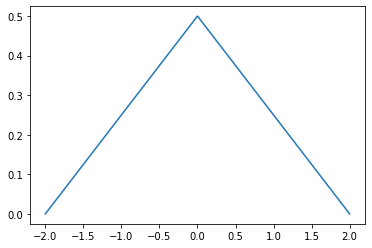

In [1759]:
n=2
inps = np.linspace(-n, n, 1000)
plt.plot(inps, [sumuniform(n, i) for i in inps])

In [1766]:
def get_perf_uniform(z, D, dim, n=0):
    # try uniform
    s = 3**-0.5
    out = 0
    rs = [sumuniform(n, r) for r in np.linspace(-n, n, n*dim)]
    for a in np.linspace(-1, 1, dim):
        for b in np.linspace(-1, 1, dim):
            # run once if n=0
            out += P(a, b, z, s, D, 0)
            for r in rs: 
                out += P(a, b, z, s, D, r)
    return out/dim/dim/(len(rs) + 1) - 0.5

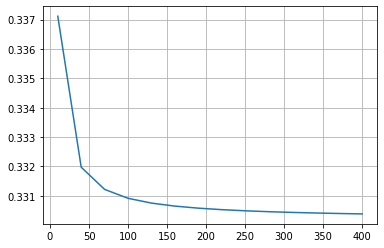

In [1771]:
inps = range(10, 410, 30)
plt.plot(inps, [D**0.5*get_perf_uniform(1, D, 100) for D in inps])
plt.grid()

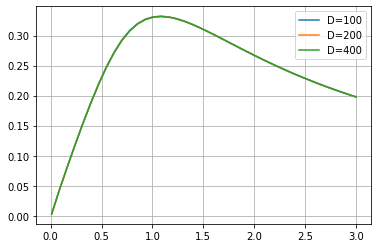

In [1772]:
zs = np.linspace(0.01, 3, 40)
for D in [100, 200, 400]:
    plt.plot(zs, [D**0.5*get_perf_uniform(z, D, 100) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

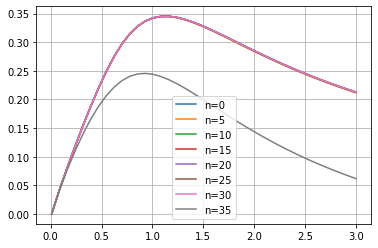

In [1775]:
D=200
zs = np.linspace(0.01, 3, 40)
for n in range(0, 40, 5):
    plt.plot(zs, [D**0.5*get_perf_uniform(z, D, 20, n) for z in zs], label="n=" + str(n))
plt.grid()
plt.legend()

In [1167]:
# def sample_perf_normal(z, D, dim):
#     # try gaussian
#     s = 1
#     out = 0
#     for a in np.random.normal(size=dim):
#         for b in np.random.normal(size=dim):
#             out += P(a, b, z, s, D)
#     return out/dim/dim - 0.5
# # this is too slow and too high-variance!!
# sample_perf_normal(1, 10, 300)

In [1389]:
def approx_perf_normal(z, D, dim):
    # try discrete gaussian
    s = 1
    out = 0
    bd = 5
    for a in np.linspace(-bd, bd, dim+1):
        for b in np.linspace(-bd, bd, dim+1):
            wt = (Phi(b + bd/dim) - Phi(b - bd/dim)) * (Phi(a + bd/dim) - Phi(a - bd/dim))
            out += wt * P(a, b, z, s, D)
    return out - 0.5

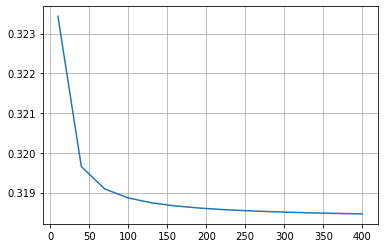

In [1390]:
# normal .. still not too good. worse than uniform
inps = range(10, 410, 30)
plt.plot(inps, [D**0.5*approx_perf_normal(1, D, 200) for D in inps])
plt.grid()

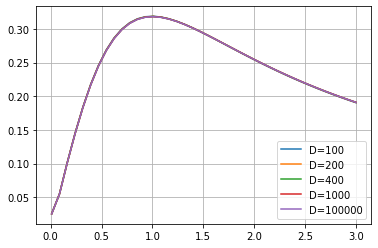

In [1504]:
zs = np.linspace(0.01, 3, 40)
for D in [100, 200, 400, 1000, 100000]:
    plt.plot(zs, [D**0.5*approx_perf_normal(z, D, 100) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

In [1516]:
1/pi

0.3183098861837907

In [1521]:
zs = np.linspace(0.99, 1.01,100)
out = [D**0.5*approx_perf_normal(z, D, 200) for z in zs]
print(zs[np.argmax(out)])
print(max(out))

1.0001010101010102
0.31818289284830836


In [1151]:
def approx_perf_hrss(z, D):
    # try threshold alg (only +1 and -1)
    s = 1
    out = 0
    for a in [-1, 1]:
        for b in [-1, 1]:
            out += P(a, b, z, s, D)
    return out/4 - 0.5

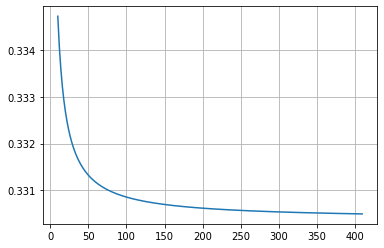

In [1173]:
# hrss works! and performs about as well... as a simple "flip". Changing z is like changing threshold..
inps = range(10, 410)
plt.plot(inps, [D**0.5*approx_perf_hrss(1, D) for D in inps], label="z=" + str(z))
plt.grid()

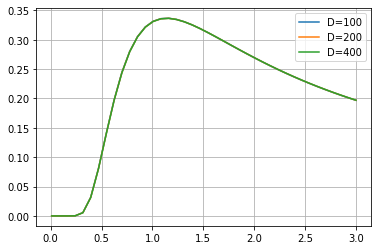

In [1174]:
zs = np.linspace(0.01, 3, 40)
for D in [100, 200, 400]:
    plt.plot(zs, [D**0.5*approx_perf_hrss(z, D) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

In [1429]:
def approx_perf_triang(z, D, dim):
    s = 6**-0.5
    out = 0
    # it's not balanced for some reason
    sumwts = 4*sum(1-abs(np.linspace(-1, 1, dim)))**2
    for a in np.linspace(-1, 1, dim):
        for b in np.linspace(-1, 1, dim):
            wt = 4*(1-abs(a))*(1-abs(b))
            out += wt*P(a, b, z, s, D)
    return out/sumwts - 0.5

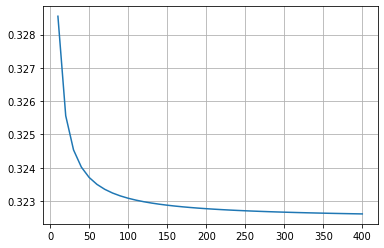

In [1431]:
inps = range(10, 410, 10)
plt.plot(inps, [D**0.5*approx_perf_triang(1, D, 100) for D in inps], label="z=" + str(z))
plt.grid()

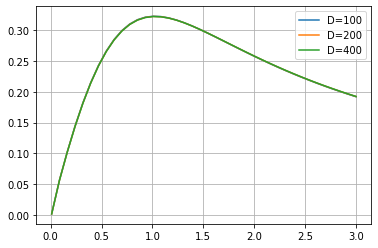

In [1433]:
zs = np.linspace(0.01, 3, 40)
for D in [100, 200, 400]:
    plt.plot(zs, [D**0.5*approx_perf_triang(z, D, 100) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

In [1432]:
def approx_perf_reverse_triang(z, D, dim):
    s = 2**-0.5
    out = 0
    # it's not balanced for some reason
    sumwts = 4*sum(abs(np.linspace(-1, 1, dim)))**2
    for a in np.linspace(-1, 1, dim):
        for b in np.linspace(-1, 1, dim):
            wt = 4*abs(a)*abs(b)
            out += wt* P(a, b, z, s, D)
    return out/sumwts - 0.5

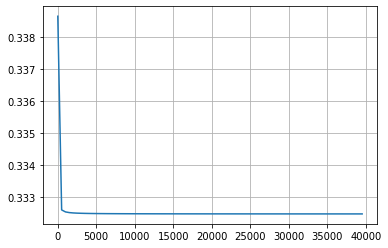

In [1447]:
inps = range(10, 40000, 500)
plt.plot(inps, [D**0.5*approx_perf_reverse_triang(1, D, 100) for D in inps])
plt.grid()

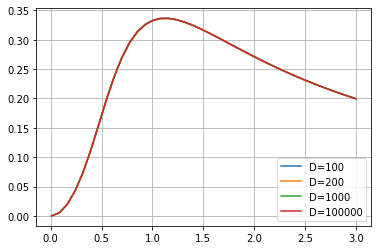

In [1444]:
zs = np.linspace(0.01, 3, 40)
for D in [100, 200, 1000,100000]:
    plt.plot(zs, [D**0.5*approx_perf_reverse_triang(z, D, 100) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

In [1872]:
import itertools

In [1898]:
from collections import Counter

In [1909]:
def approx_perf_discrete(z, D, opts, n=0):
    # generalized threshold alg (only certain opts available)
    s = np.var(opts)**0.5
    out = 0
    for a in opts:
        for b in opts:
            if n == 0:
                out += P(a, b, z, s, D)
            else:
                cnt = get_all_rs(opts, n)
                for ele in cnt:
                    out += cnt[ele]/len(opts)**n * P(a, b, z, s, D, ele)
    return out/(len(opts)**2) - 0.5

In [1910]:
def get_all_rs(opts, n):
    cnt = Counter()
    for k in itertools.product(opts, repeat=n):
        cnt[sum(k)] += 1
    return cnt

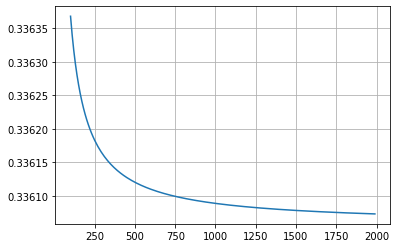

In [1935]:
#hrss, modified
inps = range(100, 2000, 10)
plt.plot(inps, [D**0.5*approx_perf_discrete(1.1, D, [-1, 1]) for D in inps])
plt.grid()

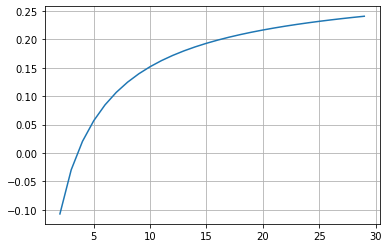

In [1934]:
#hrss, modified for triangles
inps = range(2, 30, 1)
plt.plot(inps, [D**0.5*approx_perf_discrete(1.1, D, [-1, 1], 3) for D in inps])
plt.grid()

In [1372]:
# try triangles
ns = np.random.triangular(0, 1, 1, 100)

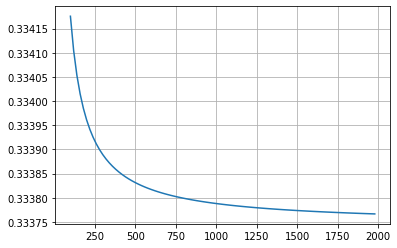

In [1437]:
inps = range(100, 2000, 20)
plt.plot(inps, [D**0.5*approx_perf_discrete(1.1, D, list(ns) + list(-ns)) for D in inps])
plt.grid()

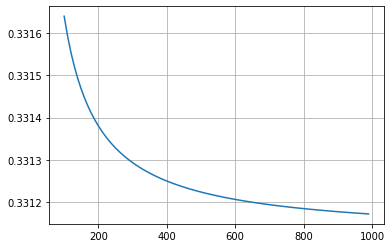

In [1944]:
inps = range(100, 1000, 10)
plt.plot(inps, [D**0.5*approx_perf_discrete(1.1, D, [-1, 0, 1]) for D in inps])
plt.grid()

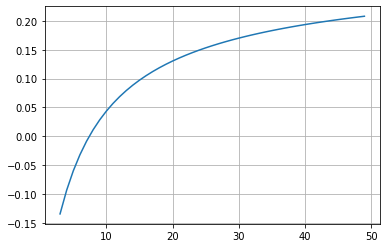

In [1943]:
# with triangles
inps = range(3, 50)
plt.plot(inps, [D**0.5*approx_perf_discrete(1.1, D, [-1, 0, 1], 5) for D in inps])
plt.grid()

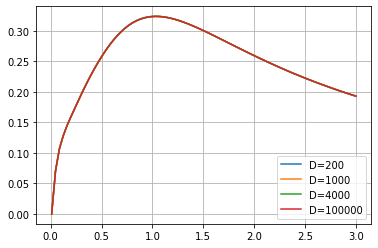

In [1494]:
# squared uniform distribution
r = (2*np.random.sample(10) - 1)**2
ns = list(r) + list(-r)
zs = np.linspace(0.01, 3, 80)
for D in [200, 1000,4000, 100000]:
    plt.plot(zs, [D**0.5*approx_perf_discrete(z, D, ns) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

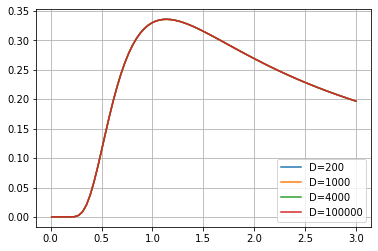

In [1493]:
# random inputs
zs = np.linspace(0.01, 3, 80)
for D in [200, 1000,4000, 100000]:
    plt.plot(zs, [D**0.5*approx_perf_discrete(z, D, [0.8, 0.7, 0.6, -0.6, -0.7, -0.8]) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

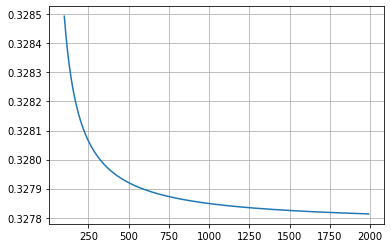

In [1347]:
inps = range(100, 2000, 10)
ns = np.random.normal(size=10)
plt.plot(inps, [D**0.5*approx_perf_discrete(1, D, np.concatenate((ns, -ns))) for D in inps])
plt.grid()
# normal performs much better than I expected

non symmetric distributions?

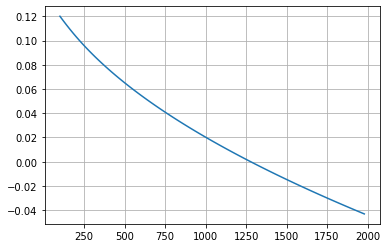

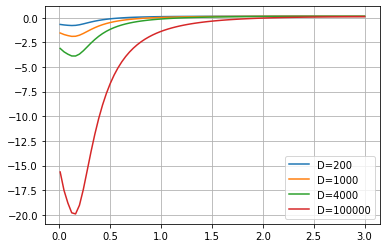

In [1498]:
ns = np.random.triangular(-1, , 1, 30)
ns = list(ns) + [-sum(ns)]
inps = range(100, 2000, 20)
plt.plot(inps, [D**0.5*approx_perf_discrete(1, D, ns) for D in inps])
plt.grid()
plt.figure()

# random inputs
zs = np.linspace(0.01,3, 80)
for D in [200, 1000,4000, 100000]:
    plt.plot(zs, [D**0.5*approx_perf_discrete(z, D, ns) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()

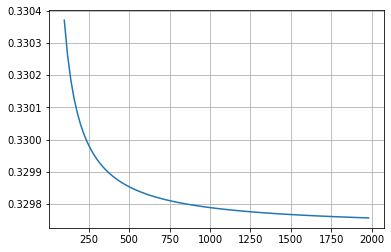

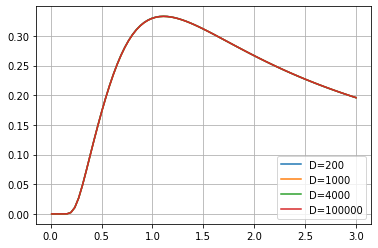

In [1502]:
ns = [-1, -0.5, 0.5, 1]
inps = range(100, 2000, 20)
plt.plot(inps, [D**0.5*approx_perf_discrete(1, D, ns) for D in inps])
plt.grid()
plt.figure()

# random inputs
zs = np.linspace(0.01,3, 80)
for D in [200, 1000,4000, 100000]:
    plt.plot(zs, [D**0.5*approx_perf_discrete(z, D, ns) for z in zs], label="D=" + str(D))
plt.grid()
plt.legend()